In [18]:
import warnings
warnings.filterwarnings('ignore')

# import gensim
from gensim.models.ldamodel import LdaModel
from gensim.models import Phrases
from gensim import corpora

from ast import literal_eval
from pickle import dump

from gensim.models.coherencemodel import CoherenceModel
#show graphs
import matplotlib.pyplot as plt

import pyLDAvis.gensim

In [19]:
#function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start):
    coherence_values = []
    for num_topics in range(start, limit):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=500)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return coherence_values

def make_corpus(data):
    #Make list of list
    mylist = []

    for i,j in data.iterrows():
        tmp = literal_eval(j.content)
        mylist.append(tmp)

    # Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
    bigram = Phrases(mylist, min_count=10)
    for idx in range(len(mylist)):
        for token in bigram[mylist[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                mylist[idx].append(token)

    # Create Dictionary
    dictionary = corpora.Dictionary(mylist)

    # Term Document Frequency
    corpus = [dictionary.doc2bow(text) for text in mylist]
    
    dump(corpus, open('corpus_LDA.pkl', 'wb'))
    dictionary.save('dictionary_LDA.gensim')
    
    return mylist,dictionary,corpus
    
def train(n_topic,corpus,dictionary):
    # Build LDA model
    lda_model = LdaModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=n_topic, 
                        random_state=666)

    #Save Model
    lda_model.save('lda.h5')
    
    return lda_model

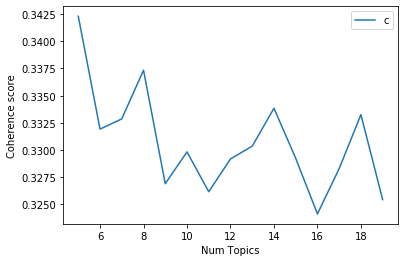

In [20]:
#Load Clean data
data = pd.read_csv('data_berita_clean.csv')

#Train
mylist,dictionary,corpus = make_corpus(data)

#search optimal topic number (5)
start=5
limit=20
coherence_values = compute_coherence_values(dictionary, corpus=corpus, 
                                                        texts=mylist, start=start, limit=limit)

x = range(start, limit)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
#Train
n_topic = 5
model = train(n_topic,corpus,dictionary)

In [22]:
# Print the Keyword in the 10 topics
topics = model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.012*"orang" + 0.011*"ajar" + 0.009*"ilmu" + 0.008*"universitas" + 0.008*"mahasiswa"')
(1, '0.012*"ajar" + 0.009*"orang" + 0.008*"sobat" + 0.007*"kuliah" + 0.007*"kerja"')
(2, '0.009*"ajar" + 0.007*"universitas" + 0.007*"didik" + 0.007*"orang" + 0.006*"kuliah"')
(3, '0.011*"orang" + 0.011*"kerja" + 0.009*"ajar" + 0.007*"kuliah" + 0.007*"teknik"')
(4, '0.016*"orang" + 0.010*"kuliah" + 0.007*"ajar" + 0.007*"sobat" + 0.006*"program"')


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis